In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../')

from sdebridge.setup import *
from sdebridge.sde import GaussianKernelSDE, MaternKernelSDE, gaussian_Q_kernel, matern_Q_kernel
from sdebridge.solver import euler_maruyama
from sdebridge.data_processing import sample_ellipse

(-1.1, 1.1, -1.1, 1.1)

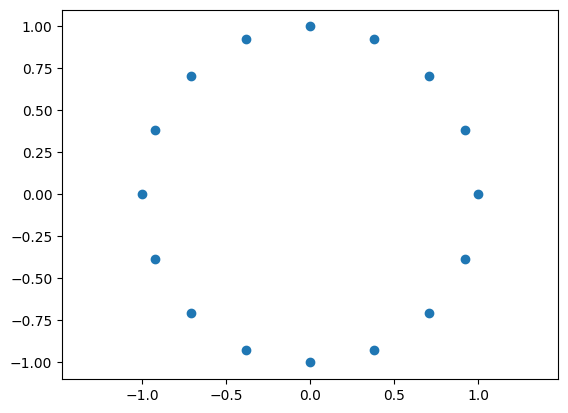

In [3]:
dim = 32
X0 = sample_ellipse(num_points=dim//2)
plt.scatter(X0.reshape(-1, 2)[:, 0], X0.reshape(-1, 2)[:, 1])
plt.axis('equal')

In [4]:
sde_params = {
    "dimension": dim,
    "num_steps": 100,
    "alpha": 1.0,
    "sigma": 1.0,
}
sde = GaussianKernelSDE(**sde_params)

def eval_gaussian_Q_cond(sigma):
    sde.sigma = sigma
    results = euler_maruyama(
        sde=sde,
        initial_vals=jnp.tile(X0, (32, 1)),
        terminal_vals=None,
    )
    trajectories = results["trajectories"]
    Qs = vmap(vmap(gaussian_Q_kernel, in_axes=(0, None, None)), in_axes=(0, None, None))(trajectories, sde.alpha, sde.sigma)
    conds = vmap(vmap(jnp.linalg.cond, in_axes=(0, None)), in_axes=(0, None))(Qs, None)
    conds = jnp.mean(conds, axis=0)
    return conds

In [5]:
sigmas = jnp.linspace(0.1, 1.0, 10)
conds = vmap(eval_gaussian_Q_cond)(sigmas)

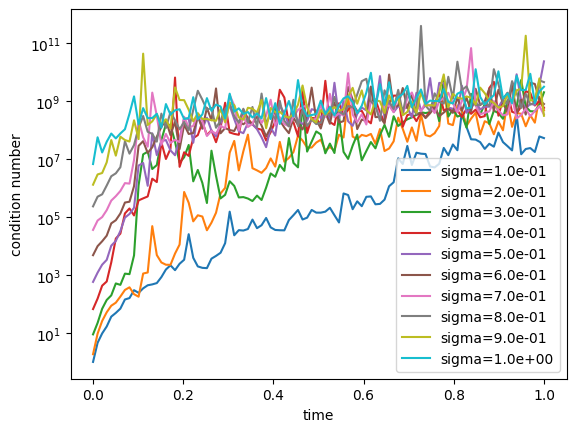

In [6]:
for i in range(10):
    plt.plot(jnp.linspace(0.0, 1.0, 100), conds[i], label=f"sigma={sigmas[i]:.1e}")
plt.legend()
plt.xlabel("time")
plt.ylabel("condition number")
plt.yscale("log")

In [7]:
sde_params = {
    "dimension": dim,
    "num_steps": 100,
    "sigma": 1.0,
    "rho": 1.0,
    "p": 2
}
sde = MaternKernelSDE(**sde_params)

def eval_matern_Q_cond(rho):
    sde.rho = rho
    results = euler_maruyama(
        sde=sde,
        initial_vals=jnp.tile(X0, (32, 1)),
        terminal_vals=None,
    )
    trajectories = results["trajectories"]
    Qs = vmap(vmap(matern_Q_kernel, in_axes=(0, None, None, None)), in_axes=(0, None, None, None))(trajectories, sde.sigma, sde.rho, sde.p)
    conds = vmap(vmap(jnp.linalg.cond, in_axes=(0, None)), in_axes=(0, None))(Qs, None)
    conds = jnp.mean(conds, axis=0)
    return conds

In [8]:
rhos = jnp.linspace(0.1, 1.0, 10)
conds = vmap(eval_matern_Q_cond)(rhos)

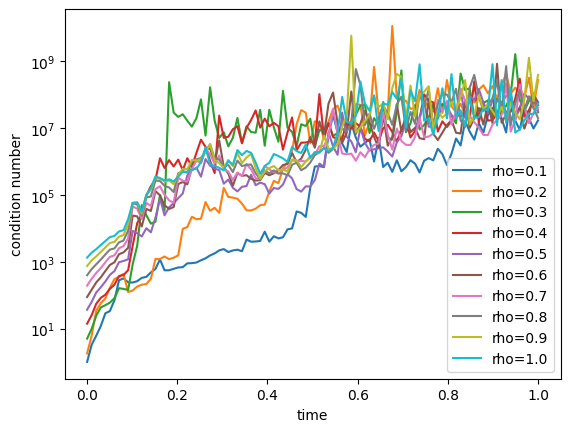

In [9]:
for i in range(10):
    plt.plot(jnp.linspace(0.0, 1.0, 100), conds[i], label=f"rho={rhos[i]:.1f}")
plt.legend()
plt.xlabel("time")
plt.ylabel("condition number")
plt.yscale("log")

In [15]:
gaussian_kernel = gaussian_Q_kernel(X0, alpha=1.0, sigma=1.0)
matern_kernel = matern_Q_kernel(X0, sigma=1.0, rho=1.0, p=1)

Text(0.5, 1.0, 'Matern kernel')

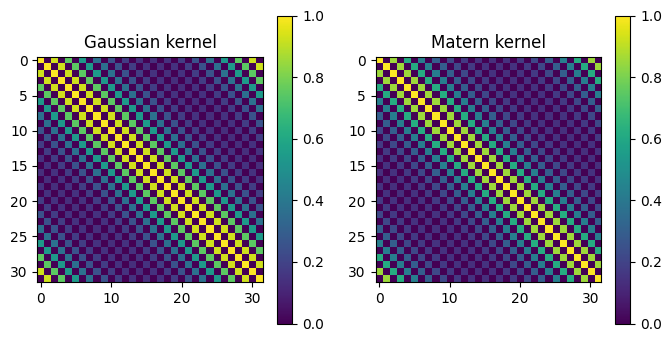

In [16]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(gaussian_kernel)
plt.colorbar()
plt.title("Gaussian kernel")
plt.subplot(122)
plt.imshow(matern_kernel)
plt.colorbar()
plt.title("Matern kernel")

In [19]:
def gaussian(d, alpha, sigma):
    return (alpha**2) * jnp.exp(-d**2 / (2 * sigma**2))

def matern(d, sigma, rho, p):
    if p == 0:
        return sigma**2 * jnp.exp(-d / rho)
    elif p == 1:
        return sigma**2 * (1 + jnp.sqrt(3) * d / rho) * jnp.exp(-jnp.sqrt(3) * d / rho)
    elif p == 2:
        return sigma**2 * (1 + jnp.sqrt(5) * d / rho + 5 * d**2 / (3 * rho**2)) * jnp.exp(-jnp.sqrt(5) * d / rho)
    else:
        raise NotImplementedError

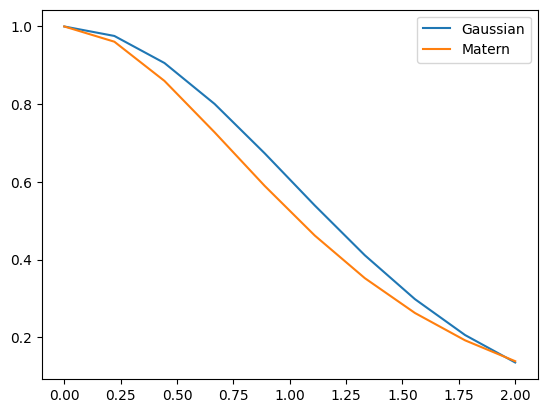

In [24]:
d = jnp.linspace(0.0, 2.0, 10)
plt.plot(d, gaussian(d, alpha=1.0, sigma=1.0), label="Gaussian")
plt.plot(d, matern(d, sigma=1.0, rho=1.0, p=2), label="Matern")
plt.legend()